In [ ]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    !apt install -y libcairo2-dev pkg-config python3-dev
    %pip install datasets tqdm sae_lens circuitsvis pycairo
    !git clone https://github.com/tom-pollak/interpretability-culture.git && cd interpretability-culture/ && pip install -e .
    !git clone https://github.com/TransformerLensOrg/TransformerLens.git && cd TransformerLens/ && git apply ../interpretability-culture/transformer_lens_final_ln.patch && pip install -e .
    exit() # reload runtime

except:
    IN_COLAB = False
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

# SAE

In [1]:
from interp.all import *
from datasets import load_dataset, DatasetDict, Dataset
from huggingface_hub import hf_hub_download
from sae_lens import SAE, HookedSAETransformer
import plotly.express as px
import json
from pathlib import Path
from functools import partial
import torch as t


device = get_device()
model = load_hooked(0, sae=True).eval().to(device) # type: ignore
assert isinstance(model, HookedSAETransformer)


def load_sae(path: str) -> SAE:
    from sae_lens import SAEConfig
    from sae_lens.toolkit.pretrained_sae_loaders import read_sae_from_disk
    from sae_lens.config import DTYPE_MAP

    weight_path = hf_hub_download(SAE_REPO_ID, path + "/sae_weights.safetensors")
    cfg_path = hf_hub_download(SAE_REPO_ID, path + "/cfg.json")
    with open(cfg_path, "r") as f:
        cfg_dict = json.load(f)
    cfg_dict, state_dict = read_sae_from_disk(
        cfg_dict=cfg_dict,
        weight_path=weight_path,
        device="cpu",
        dtype=DTYPE_MAP[cfg_dict["dtype"]],
    )
    print(cfg_dict)
    sae_cfg = SAEConfig.from_dict(cfg_dict)
    sae_cfg.device = str(device)
    sae = SAE(sae_cfg)
    sae.load_state_dict(state_dict)
    sae.eval()
    return sae


sae = load_sae("gpt-0/blocks_8_mlp_out")

dataset_full = load_dataset("tommyp111/culture-puzzles-1M", split="train")
assert isinstance(dataset_full, Dataset)
dataset = load_dataset("tommyp111/culture-puzzles-1M-partitioned")
assert isinstance(dataset, DatasetDict)

dataset_full.set_format("pt")
dataset.set_format("pt")


Moving model to device:  mps
{'architecture': 'standard', 'd_in': 512, 'd_sae': 16384, 'dtype': 'float32', 'device': 'cuda', 'model_name': 'culture-gpt-0', 'hook_name': 'blocks.8.hook_mlp_out', 'hook_layer': 8, 'hook_head_index': None, 'activation_fn_str': 'relu', 'activation_fn_kwargs': {}, 'apply_b_dec_to_input': False, 'finetuning_scaling_factor': False, 'sae_lens_training_version': '3.14.0', 'prepend_bos': True, 'dataset_path': 'tommyp111/culture-puzzles-1M', 'dataset_trust_remote_code': True, 'context_size': 405, 'normalize_activations': 'none', 'l1_coefficient': 5, 'lp_norm': 1.0, 'use_ghost_grads': False, 'normalize_sae_decoder': False, 'noise_scale': 0.0, 'decoder_orthogonal_init': False, 'init_encoder_as_decoder_transpose': True, 'mse_loss_normalization': None, 'decoder_heuristic_init': True, 'scale_sparsity_penalty_by_decoder_norm': False}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Bit of a util for later, The first and second grid are a one-shot example, so we should not include these in our eval / analysis. Let's create slices that extract the final and second final grid.

(not including the special tokens A f(A) etc. These are easy).

Another gotcha: these should be from a "stripped" batch, i.e. a batch without it's final token. I've found this edge case to be rather strange, as


I've found this edge case to be rather strange, and HookedTransformer complains about

In [2]:
final_grid_slice = slice(-100, None)
second_final_grid_slice = slice(-201, -101)

batch = dataset["contact"]["input_ids"][:5].to(device)
batch_stripped = batch[:, :]

a = batch_stripped[:1].clone()
a[:, second_final_grid_slice] = 4
a[:, final_grid_slice] = 5
print(repr_grid(a[0]))

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(X)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████

I trained on layer 8 somewhat arbitarily, let's see if we can find some interesting behaviour attributing to this MLP layer.

Looking at the loss can be less informative, because for most of the tokens it is extremely staight-forward (as shown in the first notebook).

Instead let's look at the accuracy -- if the model get's the entire grid correct. The models all have a accuracy of ~95% so this can be a much more useful measure than it would be in a text GPT (where it is pretty much impossible to predict the next passage perfectly).

I'll use the partitioned dataset so we can look at each task individually -- I think this is quite principled, since each example in the training dataset only included a single task. It makes sense for ability / features to be task specific.

(The culture may be a mix of all tasks, generated by the models themselves)

In [3]:
def zero_abl_hook(activation, hook):
    return t.zeros_like(activation)


def ablate_mlp_single_task(batch, layer, verbose=True):
    # Batch: we want to look at predictions for only the final grid
    final_grid_slice = slice(-100, None)

    # Logits: the logit predictions are shape (405,) which predict the token *after* the current.
    # aka the BOS token is not predicted in the logits, but the token *after* the final grid
    # is. Therefore we need to strip this after final grid logit off.
    final_grid_strip = slice(-101, -1)

    with t.no_grad():
        logits_orig, loss_orig = model(batch, return_type="both")
        logits_orig = logits_orig[:, final_grid_strip] # use strip on the logits

        logits_abl, loss_abl = model.run_with_hooks(
            batch,
            return_type="both",
            fwd_hooks=[(f"blocks.{layer}.hook_mlp_out", zero_abl_hook)],
        )
        logits_abl = logits_abl[:, final_grid_strip]

    # argmax => temp 0
    orig_correct = t.all(batch[:, final_grid_slice] == logits_orig.argmax(-1), dim=1)
    abl_same = t.all(logits_orig.argmax(-1) == logits_abl.argmax(-1), dim=1)
    wrong_puzzles = (~orig_correct).argwhere()[:, 0].tolist()
    abl_diff_puzzles = (~abl_same).argwhere()[:, 0].tolist()

    wrong_and_different_ablate = list(
        set(wrong_puzzles).intersection(set(abl_diff_puzzles))
    )
    wrong_because_ablate = list(set(abl_diff_puzzles).difference(set(wrong_puzzles)))

    if verbose:
        print("wrong puzzles:", wrong_puzzles)
        print("different w/ ablation:", abl_diff_puzzles)
        print("different abaltation & wrong:", wrong_and_different_ablate)
        print("wrong because of ablation:", wrong_because_ablate)
        print()

    return wrong_because_ablate


n = 100
layer = 8
for task, data in dataset.items():
    print("task:", task)
    batch = data[:n]["input_ids"].to(device)
    ablate_mlp_single_task(batch, layer)

task: contact
wrong puzzles: [15, 25, 56, 60, 62, 84]
different w/ ablation: [6, 25, 35, 39, 42, 56, 70, 91]
different abaltation & wrong: [56, 25]
wrong because of ablation: [35, 70, 6, 39, 42, 91]

task: corners
wrong puzzles: [0, 63]
different w/ ablation: [0]
different abaltation & wrong: [0]
wrong because of ablation: []

task: culture
wrong puzzles: [32, 35, 39, 54, 61, 63, 64, 66, 70, 82, 85, 86, 93, 95, 97]
different w/ ablation: [50, 61, 64, 66, 75, 86]
different abaltation & wrong: [64, 66, 61, 86]
wrong because of ablation: [50, 75]

task: detect
wrong puzzles: [1]
different w/ ablation: []
different abaltation & wrong: []
wrong because of ablation: []

task: frame
wrong puzzles: [15]
different w/ ablation: []
different abaltation & wrong: []
wrong because of ablation: []

task: grow
wrong puzzles: [33]
different w/ ablation: []
different abaltation & wrong: []
wrong because of ablation: []

task: half_fill
wrong puzzles: [62, 92]
different w/ ablation: [60, 62]
different ab

Wow! Ablating layer 8 seems to primarily only impact only the contact task, (not including culture, mix of all tasks)
Let's have a look at the quizzes the model got wrong only with ablation:

In [4]:
n = 100
layer = 8
batch = dataset["contact"][:n]["input_ids"].to(device)
wrong_because_ablate = ablate_mlp_single_task(batch, layer)

ablated_preds = []

for i in range(min(4, len(wrong_because_ablate))):
    model.add_hook("blocks.8.hook_mlp_out", zero_abl_hook)  # type: ignore
    _, abl_p = generate_and_print(model, batch[wrong_because_ablate[i]], temperature=0.0, verbose=False)
    ablated_preds.append(abl_p)
    print("*" * 100)
    model.reset_hooks()

ablated_preds = t.stack(ablated_preds)

wrong puzzles: [15, 25, 56, 60, 62, 84]
different w/ ablation: [6, 25, 35, 39, 42, 56, 70, 91]
different abaltation & wrong: [56, 25]
wrong because of ablation: [35, 70, 6, 39, 42, 91]

correct: False
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
█████████████

All the examples seem to fall victim to the same problem!

# Problem

Given the one-shot example, two of the squares "contact", and one encircles the other square with their color.

- There are often other squares that do not contact, and are therefore not encircled.
- You must use the one-shot example to deem which of the squares is encircled, and which is the encircler.

When this layer is ablated, it seems to lose the ability to lookback and see
- which square should be encircled
- which squares should be ignored


Instead it encircles every square with the encircler! (but keeps the correct color)

Using train_sae.py, I trained a model on layer 8. This uses all data in tommyp111/culture-puzzles-1M, not just this particular task. Let's see if applying the SAE weights can resolve this problem for these tasks

In [5]:
def reconstr_hook(activation, hook, sae_out):
    _, T, _ = activation.shape
    return sae_out[:, :T, :]

model.reset_hooks()

with t.no_grad():
    _, cache = model.run_with_cache(batch[wrong_because_ablate])
    h = cache[sae.cfg.hook_name].clone()
    del cache
    feature_acts = sae.encode(h)
    del h
    sae_out = sae.decode(feature_acts)


tasks_correct = []
model.add_hook(sae.cfg.hook_name, partial(reconstr_hook, sae_out=sae_out))  # type: ignore
correct, _ = generate(
    model, batch[wrong_because_ablate], temperature=0.0, verbose=False
)
model.reset_hooks()
print("All tasks correct:", t.all(correct).item())

All tasks correct: True


Yay it does! The SAE fixes the behaviour on all quizzes that the model failed on with zero ablation, this could be a good indicator that my SAE is working correctly :)

Noticably `generate` uses autoregressive sampling, rather than next token prediction. This behaviour is not reflective in cross entropy loss! This is because the model is corrected after the first mistaken token, and reverts to correct behaviour (trivially copying). This is why I'm using autoregressive sampling for evaluation, and why judging the model on its final loss can be misleading.

In [6]:
final_grid_strip = slice(-101, -1)

with t.no_grad():
    logits_orig, loss_orig = model(batch[wrong_because_ablate], return_type="both")
    logits_orig = logits_orig[:, final_grid_strip] # use strip on the logits

    logits_abl, loss_abl = model.run_with_hooks(
        batch[wrong_because_ablate],
        return_type="both",
        fwd_hooks=[(f"blocks.8.hook_mlp_out", zero_abl_hook)],
    )
    logits_abl = logits_abl[:, final_grid_strip]

    logits_sae, loss_sae = model.run_with_hooks(
        batch[wrong_because_ablate],
        return_type="both",
        fwd_hooks=[(sae.cfg.hook_name, partial(reconstr_hook, sae_out=sae_out))],
    )
    logits_sae = logits_sae[:, final_grid_strip]

# argmax => temp 0
orig_correct = batch[wrong_because_ablate][:, final_grid_slice] == logits_orig.argmax(-1)
abl_diff = logits_orig.argmax(-1) != logits_abl.argmax(-1)


print(t.all(orig_correct, dim=1), t.all(abl_diff, dim=1))

# Ground truth
print(repr_grid(batch[wrong_because_ablate][0]))

# Ablated argmax next token prediction -- prepend f(X) for visualization
print("\n*** Predicted ***")
print(repr_grid(t.cat((t.tensor([12], device=device), logits_abl.argmax(-1)[0]), dim=0)))

tensor([True, True, True, True, True, True], device='mps:0') tensor([False, False, False, False, False, False], device='mps:0')
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
████████████████████████

I wonder, given a "poisened" task, where the first token is given incorrect, will the model (with & without the SAE weights) be able to recover?

Let's get the first changed token for each batch (intuitively, there should be only a single incorrect cell, as it reverts to the correct behaviour after the first mistake)

In [7]:
from textwrap import dedent

B, T = batch.shape

abl_diff_idxs = abl_diff.argwhere()

start_idx = T + final_grid_slice.start
abl_diff_idxs[:, 1] += start_idx

wrong_next_toks = logits_abl[abl_diff].argmax(-1)
correct_next_toks = logits_orig[abl_diff].argmax(-1)

print(dedent(f"""
ablation tokens idxs that are different (where it exhibits incorrect behaviour)
there should be only a single token for each puzzle:
{abl_diff_idxs.detach().cpu().tolist()}

correct next token: {correct_next_toks.detach().cpu().tolist()}

incorrect predicted next token: {wrong_next_toks.detach().cpu().tolist()}
"""))


ablation tokens idxs that are different (where it exhibits incorrect behaviour)
there should be only a single token for each puzzle:
[[0, 305], [1, 345], [2, 367], [3, 315], [4, 310], [5, 365]]

correct next token: [5, 4, 7, 5, 7, 9]

incorrect predicted next token: [7, 8, 3, 9, 2, 2]



In [8]:
ablated_preds = []

for i in range(wrong_next_toks.shape[0]):
    wrong_tok_idx = abl_diff_idxs[i, 1].item()
    prompt = batch[wrong_because_ablate][i].clone()
    insert_token = wrong_next_toks[i]
    # insert_token = (wrong_next_toks[i] + 1) % 10 + 1 # wrong_next_toks[i]
    print(f"Inserting token {insert_token} at position {wrong_tok_idx}")
    prompt[wrong_tok_idx] = insert_token
    _, abl_p = generate_and_print(model, prompt, slice_at=wrong_tok_idx + 1, temperature=0.0, verbose=False)
    ablated_preds.append(abl_p)
    print("*" * 100)

Inserting token 7 at position 305
correct: False
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


*** Grou

Yes it does! above I've injected the incorrect token for the first cell, and the model continues the incorrect pattern (GPT is nothing if not consistent!)

/var/folders/2c/f29kcl6j44nbj5lfps43jln80000gn/T/ipykernel_81201/1561110159.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  ax1.bar(np.arange(15), F.log_softmax(logits_orig[abl_diff][2]).detach().cpu().numpy())
/var/folders/2c/f29kcl6j44nbj5lfps43jln80000gn/T/ipykernel_81201/1561110159.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  ax2.bar(np.arange(15), F.log_softmax(logits_abl[abl_diff][2]).detach().cpu().numpy())
/var/folders/2c/f29kcl6j44nbj5lfps43jln80000gn/T/ipykernel_81201/1561110159.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  ax5.bar(np.arange(15), F.log_softmax(logits_sae[abl_diff][2]).detach().cpu().numpy())
/var/folders/2c/f29kcl6j44nbj5lfps43jln80000gn/T/ipykernel_81201/1561110159.py:20: UserWarning: Implicit dimens

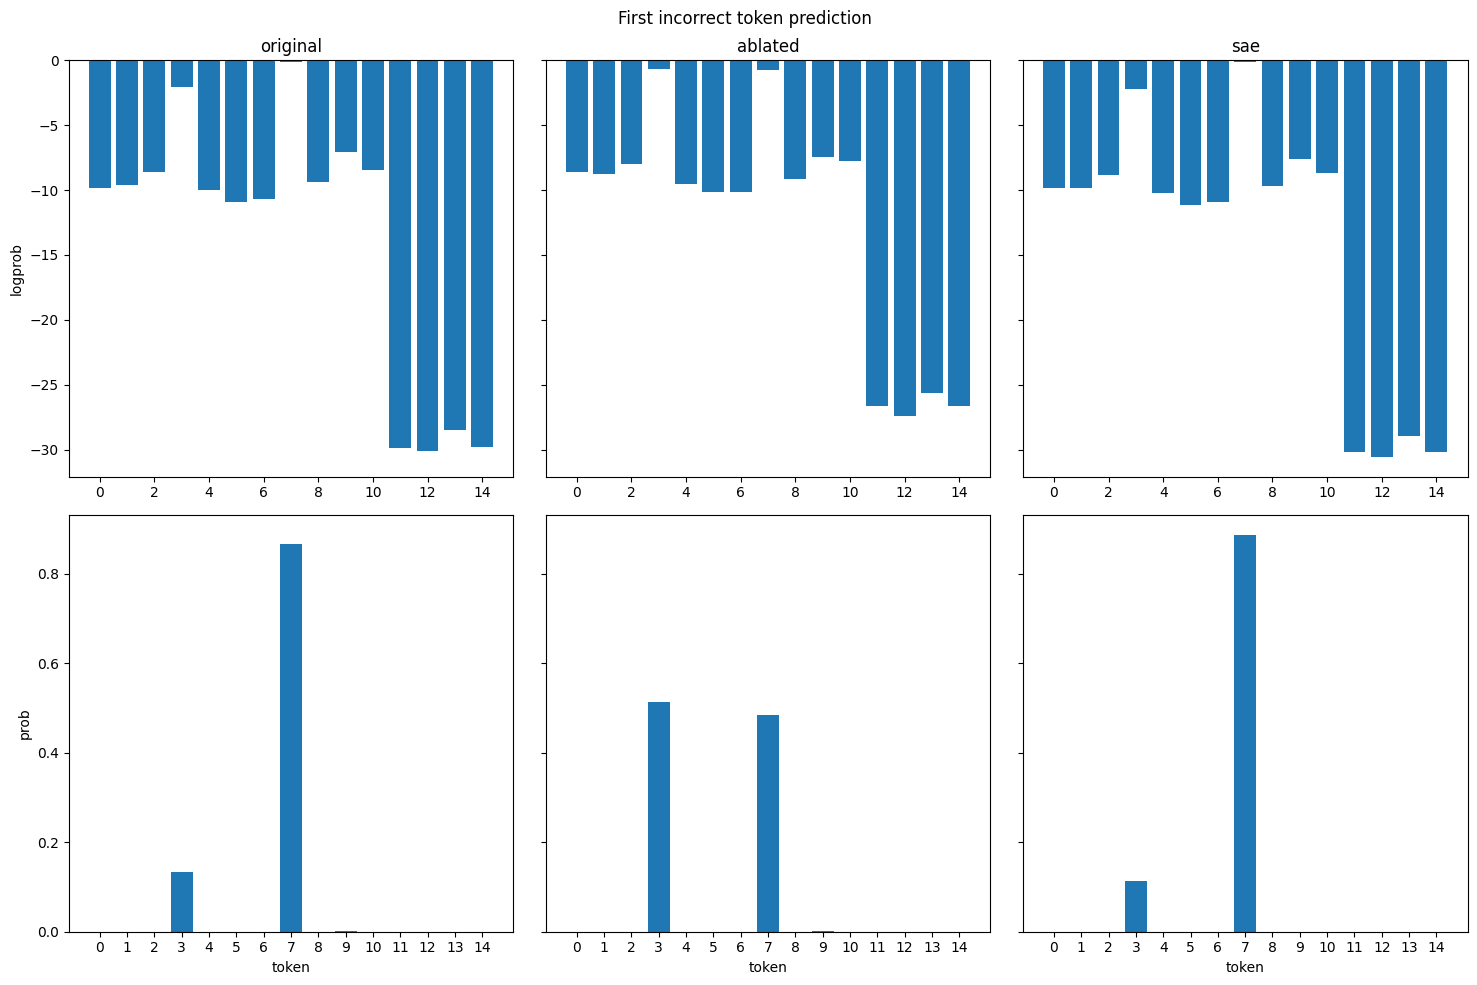

In [9]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

fig, ((ax1, ax2, ax5), (ax3, ax4, ax6)) = plt.subplots(2, 3, figsize=(15, 10), sharey='row')

fig.suptitle("First incorrect token prediction")

# Log probabilities (top row)
ax1.bar(np.arange(15), F.log_softmax(logits_orig[abl_diff][2]).detach().cpu().numpy())
ax2.bar(np.arange(15), F.log_softmax(logits_abl[abl_diff][2]).detach().cpu().numpy())
ax5.bar(np.arange(15), F.log_softmax(logits_sae[abl_diff][2]).detach().cpu().numpy())
ax1.set_title("original")
ax2.set_title("ablated")
ax5.set_title("sae")
ax1.set_ylabel("logprob")
ax3.set_ylabel("prob")

# Probabilities (bottom row)
ax3.bar(np.arange(15), F.softmax(logits_orig[abl_diff][2]).detach().cpu().numpy())
ax4.bar(np.arange(15), F.softmax(logits_abl[abl_diff][2]).detach().cpu().numpy())
ax6.bar(np.arange(15), F.softmax(logits_sae[abl_diff][2]).detach().cpu().numpy())

# Set x-axis labels and ticks
for ax in (ax3, ax4, ax6):
    ax.set_xlabel("token")
    ax.set_xticks(np.arange(15))

# Adjust layout and display
plt.tight_layout()
plt.show()

Ok let's see what the top activations are when the model attempts to predict the token:

In [10]:
from collections import Counter
interesting_acts = feature_acts[:, final_grid_strip][abl_diff] # i've ran out of names
values, indices = interesting_acts.topk(3, dim=1)
counts = Counter(indices.flatten().tolist())
print(counts)
print(indices)
print(values)

Counter({10024: 3, 9081: 3, 12657: 2, 10175: 2, 13557: 2, 1525: 2, 13626: 1, 16302: 1, 1612: 1, 12159: 1})
tensor([[10024, 13626, 16302],
        [ 1612,  9081, 12159],
        [12657, 10175, 13557],
        [10024, 13557, 10175],
        [ 9081, 12657,  1525],
        [ 9081, 10024,  1525]], device='mps:0')
tensor([[3.7777, 2.6142, 2.6065],
        [3.4609, 2.7054, 2.6439],
        [3.2862, 2.3468, 2.3291],
        [3.5922, 2.9958, 2.8624],
        [2.7205, 2.6991, 2.5194],
        [3.5886, 3.1190, 3.1102]], device='mps:0')


10024 & 9081 consistently activate these on this circuit and seem have to give large activations. Now let's see if they boost the correct cell.

I'd like to attempt is to find the features that cause the model to correctly exhibit the correct encircling behaviour.

This seems like a perfect task for attribution patching! But the problem is I'm not sure what the clean and corrupted examples should be.

We need a clean positive example and negative example, which are as close 

Positive:
"The Eiffel Tower is in [Paris]"
Negative:
"The Colosseum is in [Rome]"

However we only have a single token that starts the encirclement, and we want to find the difference between the (correct) blank 0 token and the encircle token.

In [11]:
def run_batch(batch):
    wrong_because_ablate = ablate_mlp_single_task(batch, 8, verbose=False)

    with t.no_grad():
        logits_orig, loss_orig = model(batch[wrong_because_ablate], return_type="both")
        logits_orig = logits_orig[:, final_grid_strip] # use strip on the logits

        logits_abl, loss_abl = model.run_with_hooks(
            batch[wrong_because_ablate],
            return_type="both",
            fwd_hooks=[(f"blocks.8.hook_mlp_out", zero_abl_hook)],
        )
        logits_abl = logits_abl[:, final_grid_strip]

    # argmax => temp 0
    orig_correct = batch[wrong_because_ablate][:, final_grid_slice] == logits_orig.argmax(-1)
    abl_diff = logits_orig.argmax(-1) != logits_abl.argmax(-1)

    tokens = batch[wrong_because_ablate]
    return tokens, abl_diff, logits_orig, logits_abl

def get_incorrect_data(n, bs):
    tokens, abl_diff, logits_orig, logits_abl = [], [], [], []
    for i in range(0, n, bs):
        batch = dataset["contact"][i:i+bs]["input_ids"].to(device) # type: ignore
        tks, a, lo, la = run_batch(batch)
        tokens.append(tks)
        abl_diff.append(a)
        logits_orig.append(lo)
        logits_abl.append(la)
    return t.cat(tokens), t.cat(abl_diff), t.cat(logits_orig), t.cat(logits_abl)

tokens, abl_diff, logits_orig, logits_abl = get_incorrect_data(1000, 100)
wrong_next_toks = logits_abl[abl_diff].argmax(-1)
correct_next_toks = logits_orig[abl_diff].argmax(-1)
print(abl_diff.argwhere())

tensor([[ 0,  0],
        [ 1, 40],
        [ 2, 62],
        [ 3, 10],
        [ 4,  5],
        [ 5, 60],
        [ 6, 42],
        [ 7, 30],
        [ 8, 11],
        [ 9,  2],
        [10, 83],
        [11,  0],
        [12, 50],
        [13, 70],
        [14, 21],
        [15, 43],
        [16,  1],
        [17, 25],
        [18,  0],
        [19, 34],
        [20, 16],
        [21, 20],
        [22,  4],
        [23, 60],
        [24, 46],
        [25, 36],
        [26,  2],
        [27,  0],
        [28, 67],
        [29, 42],
        [30,  0],
        [31, 40],
        [32, 61],
        [33, 10]], device='mps:0')


In [12]:
def logits_to_ave_logit_diff(logits, logit_mask, answer_tokens, per_prompt=False):
    final_logits = logits[logit_mask]
    answer_logits = final_logits.gather(dim=-1, index=answer_tokens)
    answer_logit_diff = answer_logits[:, 0] - answer_logits[:, 1]
    if per_prompt:
        return answer_logit_diff
    else:
        return answer_logit_diff.mean()

answer_tokens = t.stack((correct_next_toks, wrong_next_toks), dim=-1)

logit_diff_orig = logits_to_ave_logit_diff(logits_orig, abl_diff, answer_tokens, per_prompt=True)
logit_diff_abl = logits_to_ave_logit_diff(logits_abl, abl_diff, answer_tokens, per_prompt=True)
print(f"Logit diff orig: {logit_diff_orig.detach().cpu().numpy()}\nLogit diff ablated: {logit_diff_abl.detach().cpu().numpy()}")

Logit diff orig: [1.0029383  0.82365704 1.877614   0.7686534  2.070815   2.057085
 5.7843413  5.3268385  4.3005905  0.4019723  6.0873103  2.6238186
 0.8568611  0.7197614  1.7115583  2.7312202  1.2911334  3.5430584
 1.501092   0.6067748  1.5617104  0.94733477 1.8229198  4.2228765
 0.6258068  6.1052732  0.8218169  5.0727687  0.977581   1.2242465
 4.670813   1.1907172  0.07718468 2.0836923 ]
Logit diff ablated: [-0.20423317 -0.9448204  -0.06239128 -1.7862902  -1.1123166  -0.69584274
 -0.29916525 -0.35348892 -0.35964966 -1.952816   -0.3415799  -1.466599
 -0.56824684 -2.3568254  -0.15017366 -0.469553   -1.8359513  -2.0408742
 -0.9231982  -0.11771679 -1.9845371  -0.04965353 -0.1403017  -3.4998887
 -0.27950478 -2.0194263  -0.6815729  -2.0165815  -1.024786   -0.17355347
 -0.43288708 -0.8112502  -0.5998826  -0.51377535]


 Ok let's try training a 1D "feature multiplier" that would mask feature weights that weren't important to reconstruction loss. I'm not sure if this is principled or correct, but it worked for me.
 
 We'll init with a zero vector (equivalent to ablated) and train with a very high weight decay.

In [108]:
from torch import optim


feat_mult_clf = t.zeros(sae.cfg.d_sae, requires_grad=True, device=device)
for param in sae.parameters(): param.requires_grad = False
for param in model.parameters(): param.requires_grad = False


def reconstr_loss(logits, logit_diff, abl_diff, answer_tokens):
    return (logits_to_ave_logit_diff(logits, abl_diff, answer_tokens, per_prompt=True) - logit_diff).sum()

def clf_mult_hook(activation, hook, feat_mult_clf):
    return (activation * feat_mult_clf)

model.reset_hooks()
sae.add_hook("hook_sae_acts_post", partial(clf_mult_hook, feat_mult_clf=feat_mult_clf)) # type: ignore
model.add_sae(sae)

optimizer = optim.Adam([feat_mult_clf], lr=2e-3, weight_decay=2.)

N, T = tokens.shape
batch_size = 4
losses = []

for step in range(2000):
    b_idxs = t.randperm(N)[:batch_size]
    batch = tokens[b_idxs]
    logits = model(batch)
    loss = -1 * reconstr_loss(logits[:, final_grid_strip], logit_diff_orig[b_idxs], abl_diff[b_idxs], answer_tokens[b_idxs])
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    optimizer.zero_grad()
    neurons_active = (feat_mult_clf > 0.1).sum().item()
    if step % 100 == 0:
        ls = losses[-100:]
        print(f"{step:04} | loss: {sum(ls)/len(ls):07.4f} | features active: {neurons_active}")


sae.reset_hooks()
model.reset_saes()

0000 | loss: 11.1273 | features active: 0
0100 | loss: 12.3545 | features active: 13
0200 | loss: 11.2902 | features active: 13
0300 | loss: 11.1016 | features active: 13
0400 | loss: 11.3091 | features active: 13
0500 | loss: 10.3988 | features active: 13
0600 | loss: 10.3527 | features active: 13
0700 | loss: 10.5671 | features active: 13
0800 | loss: 10.2711 | features active: 12
0900 | loss: 10.9290 | features active: 13
1000 | loss: 10.3994 | features active: 13
1100 | loss: 10.9495 | features active: 12
1200 | loss: 10.7591 | features active: 12
1300 | loss: 10.5788 | features active: 12
1400 | loss: 11.1350 | features active: 14
1500 | loss: 10.5646 | features active: 12
1600 | loss: 10.2861 | features active: 11
1700 | loss: 10.3135 | features active: 14
1800 | loss: 10.6783 | features active: 13
1900 | loss: 10.7618 | features active: 13


In [16]:
print("most positive")
print(t.topk(feat_mult_clf, k=25))
print("\nmost negative")
print(t.topk(-feat_mult_clf, k=10))

most positive
torch.return_types.topk(
values=tensor([0.6660, 0.2989, 0.2759, 0.2623, 0.2233, 0.2170, 0.2084, 0.1969, 0.1519,
        0.1409, 0.1222, 0.1193, 0.1076, 0.0867, 0.0792, 0.0741, 0.0689, 0.0686,
        0.0671, 0.0641, 0.0632, 0.0624, 0.0610, 0.0544, 0.0530],
       device='mps:0', grad_fn=<TopkBackward0>),
indices=tensor([10024, 16302, 13626,  9081,  1461, 12552,  1525, 12657, 13557, 10175,
        13497,  3836,  4982,  7012, 12500,  2535, 15531,  8496, 14906,  6166,
        14419, 13926,  5822,  1612, 14509], device='mps:0'))

most negative
torch.return_types.topk(
values=tensor([0.0679, 0.0659, 0.0282, 0.0225, 0.0202, 0.0191, 0.0178, 0.0160, 0.0151,
        0.0145], device='mps:0', grad_fn=<TopkBackward0>),
indices=tensor([15498,  1048,  6524,  7332,  2723, 15751,  3541,  9269, 15899,   226],
       device='mps:0'))


Ok interesting! 13 neurons out of the 16k were marked important above a 0.1 weighting 10024 is the top neuron by a significant margin, and 9081 is also quite high. This lines up quite nicely with the activations above.

Comparing that with the topk counter method:

In [17]:
batch_size = 4

feature_acts = []
with t.no_grad():
    for i in range(0, len(tokens), batch_size):
        batch_tokens = tokens[i:i+batch_size]

        *_, cache = model.run_with_cache(batch_tokens)
        h = cache[sae.cfg.hook_name].clone()
        del cache
        act = sae.encode(h)
        del h
        feature_acts.append(act)

feature_acts = t.cat(feature_acts, dim=0)

In [18]:
from collections import Counter
interesting_acts = feature_acts[:, final_grid_strip][abl_diff]
values, indices = interesting_acts.topk(3, dim=1)
counts = Counter(indices.flatten().tolist())
print(counts)

Counter({10024: 14, 16302: 9, 13557: 9, 9081: 8, 12657: 8, 13626: 7, 10175: 7, 1525: 4, 15498: 3, 12552: 3, 1461: 3, 5822: 3, 1612: 2, 7332: 2, 1048: 2, 12159: 1, 7366: 1, 5932: 1, 8176: 1, 4214: 1, 14419: 1, 11888: 1, 15592: 1, 7857: 1, 15531: 1, 14509: 1, 2348: 1, 15934: 1, 15260: 1, 12500: 1, 5041: 1, 115: 1, 3836: 1})


Now let's visualize what the output looks like when we mask out all features but 10024

In [21]:
keep_neurons = [10024]
mask = t.zeros_like(feat_mult_clf)
mask[keep_neurons] = 1

corrects = []

def only_certain_neurons(activation, hook):
    return activation * mask

def with_sae_hook(sae_hook):
    def _decorator(f):
        def _inner(*args, **kwargs):
            sae.add_hook("hook_sae_acts_post", sae_hook)
            model.add_sae(sae)

            try:
                return f(*args, **kwargs)
            finally:
                model.reset_hooks()
                model.reset_saes()
                sae.reset_hooks()
        return _inner
    return _decorator


@with_sae_hook(only_certain_neurons)
def gen():
    corrects = []
    for i in range(tokens.shape[0]):
        c, _ = generate_and_print(model, tokens[i], temperature=0.0, verbose=True)
        corrects.append(c)
    return corrects



corrects = gen()
print("\n", "*" * 100)
print(corrects)


  0%|          | 0/100 [00:00<?, ?it/s]

correct: True
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


f(X)
██████████████████████████████
███████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: False
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


*** Ground Truth ***

f(X)
███████████████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: True
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


f(X)
██████████████████████████████
███████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: False
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


*** Ground Truth ***

f(X)
███████████████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: False
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


*** Ground Truth ***

f(X)
███████████████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: False
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


*** Ground Truth ***

f(X)
███████████████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: False
X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(X)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


*** Ground Truth ***

f(Y)
███████████████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: True
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


f(X)
██████████████████████████████
███████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: True
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


f(X)
██████████████████████████████
███████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: False
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


*** Ground Truth ***

f(X)
███████████████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: False
X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(X)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


*** Ground Truth ***

f(Y)
███████████████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: False
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


*** Ground Truth ***

f(X)
███████████████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: False
X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(X)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


*** Ground Truth ***

f(Y)
███████████████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: False
X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(X)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


*** Ground Truth ***

f(Y)
███████████████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: True
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


f(X)
██████████████████████████████
███████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: False
f(X)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


*** Ground Truth ***

Y
███████████████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: False
X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(X)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


*** Ground Truth ***

f(Y)
███████████████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: False
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


*** Ground Truth ***

f(X)
███████████████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: False
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


*** Ground Truth ***

f(X)
███████████████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: False
X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(X)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


*** Ground Truth ***

f(Y)
███████████████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: False
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


*** Ground Truth ***

f(X)
███████████████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: True
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


f(X)
██████████████████████████████
███████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: False
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


*** Ground Truth ***

f(X)
███████████████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: False
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


*** Ground Truth ***

f(X)
███████████████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: False
f(X)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


*** Ground Truth ***

Y
███████████████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: False
X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(X)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


*** Ground Truth ***

f(Y)
███████████████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: False
X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(X)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


*** Ground Truth ***

f(Y)
███████████████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: False
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


*** Ground Truth ***

f(X)
███████████████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: False
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


*** Ground Truth ***

f(X)
███████████████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: True
X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(X)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


f(Y)
██████████████████████████████
███████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: True
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


f(X)
██████████████████████████████
███████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: False
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


*** Ground Truth ***

f(X)
███████████████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: True
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


f(X)
██████████████████████████████
███████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: True
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


f(X)
██████████████████████████████
███████

Pretty hit or miss! let's vary the number of features and mutliplier (I think the activation magnitude may play a role here)

In [89]:
def mask_features(activation, hook):
    global mask
    return activation * mask

@t.no_grad()
@with_sae_hook(mask_features)
def run():
    logits_keep = model(tokens, return_type="logits")
    accuracy = t.all(tokens[:, final_grid_slice] == logits_keep[:, final_grid_strip].argmax(-1), dim=-1).float().mean().item()
    print(f"accuracy: {accuracy:.4f}")
    return accuracy

def top_feats_mask(k, v=1):
    idxs = t.topk(feat_mult_clf, k=k).indices
    mask = t.zeros_like(feat_mult_clf)
    mask[idxs] = v
    return mask

accuracies = {}
for v in (1, 3, 5, 10, 15, 20):
    accuracies[v] = {}
    print(f"#### val: {v} ####")
    for k in (1, 3, 5, 15, 25, 50):
        print(f"top {k}: ", end="")
        mask = top_feats_mask(k, v=v)
        acc = run()
        accuracies[v][k] = acc
    print("*" * 100)

mask = t.ones_like(feat_mult_clf)
sae_acc = run()
print(f"sae: {acc:.4f}")

#### val: 1 ####
top 1: accuracy: 0.2941
top 3: accuracy: 0.4412
top 5: accuracy: 0.5294
top 15: accuracy: 0.6765
top 25: accuracy: 0.7941
top 50: accuracy: 0.8824
****************************************************************************************************
#### val: 3 ####
top 1: accuracy: 0.5000
top 3: accuracy: 0.6176
top 5: accuracy: 0.7353
top 15: accuracy: 0.8235
top 25: accuracy: 0.8235
top 50: accuracy: 0.7941
****************************************************************************************************
#### val: 5 ####
top 1: accuracy: 0.5588
top 3: accuracy: 0.6765
top 5: accuracy: 0.7647
top 15: accuracy: 0.7647
top 25: accuracy: 0.7353
top 50: accuracy: 0.7353
****************************************************************************************************
#### val: 10 ####
top 1: accuracy: 0.6176
top 3: accuracy: 0.6471
top 5: accuracy: 0.6765
top 15: accuracy: 0.5882
top 25: accuracy: 0.5588
top 50: accuracy: 0.5588
****************************************

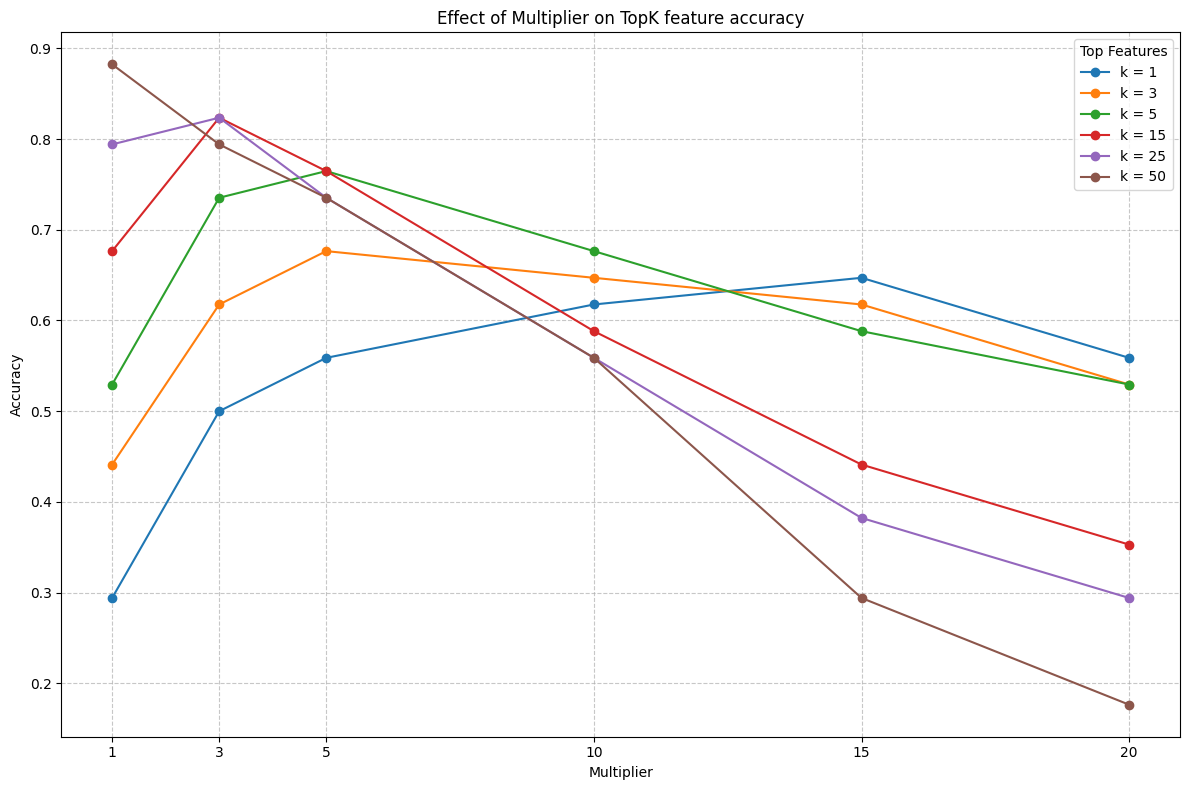

Plot saved as 'value_based_accuracy_plot.png'


In [90]:

plt.figure(figsize=(12, 8))

v_values = list(accuracies.keys())
k_values = list(accuracies[1].keys())  # Assuming all v have the same k values

for k in k_values:
    acc_values = [accuracies[v][k] for v in v_values]
    plt.plot(v_values, acc_values, marker='o', label=f'k = {k}')

plt.xlabel('Multiplier')
plt.ylabel('Accuracy')
plt.title('Effect of Multiplier on TopK feature accuracy')
plt.legend(title='Top Features')
plt.grid(True, linestyle='--', alpha=0.7)

# Ensure x-axis ticks are at the v values
plt.xticks(v_values)

plt.tight_layout()
plt.savefig('value_based_accuracy_plot.png', dpi=300)

plt.show()

print("Plot saved as 'value_based_accuracy_plot.png'")

Finally let's try "steering" the SAE to do the behaviour on different tasks:

In [62]:


def steer(activation, hook):
    global mask, mult
    activation[:, :, mask.bool()] = mult
    return activation

@with_sae_hook(steer)
def gen_frame():
    generate_and_print(model, dataset["frame"][0]['input_ids'].to(device), temperature=0.0, verbose=True)

# mult = 10
# print("mult:", mult)
# gen_frame()
# print("*" * 100)
mult = 12
print("mult:", mult)
gen_frame()


mult: 10


  0%|          | 0/100 [00:00<?, ?it/s]

correct: True
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


f(X)
██████████████████████████████
███████

  0%|          | 0/100 [00:00<?, ?it/s]

correct: False
Y
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

f(Y)
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████

X
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████
██████████████████████████████


*** Ground Truth ***

f(X)
███████████████

**Mega fail!**

`W_dec` of 10024:

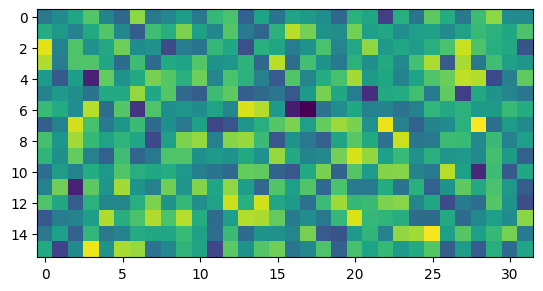

In [103]:
plt.imshow(sae.W_dec[10024].detach().cpu().numpy().reshape(16,32))
plt.show()

In [ ]:
from sae_dashboard.sae_vis_data import SaeVisConfig
from sae_dashboard.sae_vis_runner import SaeVisRunner

test_feature_idx_gpt = [k for k,c in counts.items() if c >= 2]

feature_vis_config_gpt = SaeVisConfig(
    hook_point=sae.cfg.hook_name,
    features=test_feature_idx_gpt,
    minibatch_size_features=64,
    minibatch_size_tokens=256,
    verbose=True,
    device=str(device),
)

visualization_data_gpt = SaeVisRunner(feature_vis_config_gpt).run(
    encoder=sae,
    model=model, # type: ignore
    tokens=batch[wrong_because_ablate],
)

from sae_dashboard.data_writing_fns import save_feature_centric_vis, save_prompt_centric_vis

save_feature_centric_vis(sae_vis_data=visualization_data_gpt, filename="demo_feature_dashboards.html")


Forward passes to cache data for vis:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting vis data from cached data:   0%|          | 0/6 [00:00<?, ?it/s]

┏━━━━━━┳━━━━━━┳━━━━━━━┓
┃ Task ┃ Time ┃ Pct % ┃
┡━━━━━━╇━━━━━━╇━━━━━━━┩
└──────┴──────┴───────┘

Saving feature-centric vis:   0%|          | 0/6 [00:00<?, ?it/s]

### Finding the sparsity

In [11]:
feature_acts = []

n = 64 # 384
bs = 32

with t.no_grad():
    for i in range(0, n // bs, bs):
        batch_tokens = dataset_full[i : i + 32]["input_ids"].to(device)
        _, cache = model.run_with_cache(batch_tokens, names_filter=[sae.cfg.hook_name])
        acts = sae.encode(cache[sae.cfg.hook_name])
        feature_acts.append(acts[:, final_grid_slice])
        del cache

# ignore the bos token, get the number of features that activated in each token, averaged accross batch and position
feature_acts = t.cat(feature_acts, dim=0)[:, 1:]

l0 = (feature_acts > 0).float().sum(-1).detach()
print("average l0", l0.mean().item())
px.histogram(l0.flatten().cpu().numpy()).show()

average l0 64.07418060302734


In [10]:
feature_acts_contact = []

n = 64 # 384
bs = 32

with t.no_grad():
    for i in range(0, n // bs, bs):
        batch_tokens = dataset["contact"][i : i + 32]["input_ids"].to(device)
        _, cache = model.run_with_cache(batch_tokens, names_filter=[sae.cfg.hook_name])
        acts = sae.encode(cache[sae.cfg.hook_name])
        feature_acts_contact.append(acts[:, final_grid_slice])
        del cache

# ignore the bos token, get the number of features that activated in each token, averaged accross batch and position
feature_acts_contact = t.cat(feature_acts_contact, dim=0)[:, 1:]

l0 = (feature_acts_contact > 0).float().sum(-1).detach()
print("average l0", l0.mean().item())
px.histogram(l0.flatten().cpu().numpy()).show()

average l0 66.12815856933594


In [7]:
from sae_lens.analysis.feature_statistics import (
    get_W_U_W_dec_stats_df,
)

W_dec = sae.W_dec.detach().cpu()

# calculate the statistics of the logit weight distributions
W_U_stats_df_dec, dec_projection_onto_W_U = get_W_U_W_dec_stats_df(
    W_dec, model, cosine_sim=False
)
display(W_U_stats_df_dec)

,feature,mean,std,skewness,kurtosis
0,0,-0.008411,0.045923,-0.333212,2.507046
1,1,-0.000265,0.000574,-0.027515,2.221524
2,2,0.000290,0.008415,0.643761,1.989931
3,3,0.003134,0.063906,1.321536,4.109923
4,4,0.005751,0.010995,-0.162024,1.508211
...,...,...,...,...,...
16379,16379,0.040740,0.117200,0.925136,2.097044
16380,16380,0.011986,0.103558,0.865758,2.042682
16381,16381,-0.005119,0.022454,-0.541232,1.837249
16382,16382,-0.034678,0.093033,-0.978822,2.134010
